In [1]:
## Convert lightning checkpoint into torch checkpoint
import torch
  
# Path to your PyTorch Lightning checkpoint
lightning_checkpoint_path = '/media/nas2/Aref/share/continual_learning/models/resnet50/checkpoints/epoch=59-step=219420-v_loss=0.1618-v_acc=0.9475.ckpt'

# Load the checkpoint
checkpoint = torch.load(lightning_checkpoint_path)

model_state_dict = checkpoint['state_dict']
# model_state_dict
# PyTorch Lightning prefixes each model parameter key with 'model.'
# You may need to remove this prefix if you're loading the state dict into a plain PyTorch model.
model_state_dict = {key.replace('classifier.', '', 1): value for key, value in model_state_dict.items()}
# model_state_dict

### From github repo: https://github.com/donlee90/icarl/blob/master/model.py

In [2]:
import os
import numpy as np
import torch
from torchvision.io import read_image
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from pathlib import Path
from torchvision.models import resnet18,resnet50

class CustomDataset(Dataset):
    def __init__(self, txt_file_paths=None, transform=None, images_np=None, labels_np=None):
        """
        Initialize the dataset with either a list of .txt files containing image paths or numpy arrays of images and labels.
        
        Args:
            txt_file_paths (list of str): List of paths to .txt files, each containing image paths. Each .txt file represents a class.
            transform (callable, optional): Optional transform to be applied on a sample.
            images_np (numpy.ndarray, optional): Numpy array of images (used when not using .txt files for image paths).
            labels_np (numpy.ndarray, optional): Numpy array of labels (used when not using .txt files for image paths).
        """
        self.transform = transform
        self.images_np = images_np
        self.labels_np = labels_np
        self.image_paths = []
        self.labels = []

        if txt_file_paths is not None:
            # Load image paths and labels from .txt files
            for label, txt_path in enumerate(txt_file_paths):
                with open(txt_path, 'r') as f:
                    for line in f:
                        self.image_paths.append(line.strip())  # Remove newline characters
                        self.labels.append(label)  # The index of the .txt file is the label

        self.from_numpy = images_np is not None and labels_np is not None
        
    def __len__(self):
        if self.from_numpy:
            return len(self.images_np)
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        if self.from_numpy:
            # Handle numpy array data
            image = torch.from_numpy(self.images_np[idx])
            label = self.labels_np[idx]

            
            # # Convert numpy image to PIL Image if necessary before applying transform
            # if self.transform is not None:
            #     image = Image.fromarray)(image)
            #     image = self.transform(image)
        else:
            # Load image and label from the list populated from .txt files
            img_path = self.image_paths[idx]
            label = self.labels[idx]
            image = Image.open(img_path)  # Assuming these are paths to images

            if image.size[0]<256 or image.size[1]<256:
                resize_transform = transforms.Resize(256)
                image = resize_transform(image)
            
            if image.mode=='L':
                image = image.convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
        return idx, image, label




In [3]:
# model = resnet50(weights=False)
# model.fc = nn.Linear(model.fc.in_features, 2)

# model.load_state_dict(model_state_dict)

In [6]:
# Hyper Parameters
num_epochs = 50
batch_size = 64
learning_rate = 0.01

class iCaRLNet(nn.Module):
    def __init__(self, feature_size, n_classes, state_dict):
        # Feature size is the size of feature extractor output
        # n_classes is the nunber of classes in the Classifier, in our case this is 2
        # State dict is the dictionary of weight that was pretrained.
        
        # Network architecture
        super(iCaRLNet, self).__init__()
        self.feature_extractor = resnet50(weights=None)
        
        # Changing the model architecture just to load the pretrained state_dict
        self.feature_extractor.fc = nn.Linear(self.feature_extractor.fc.in_features, 2)

        self.feature_extractor.load_state_dict(model_state_dict)
        ###############################################################
        
        # self.feature_extractor.fc = nn.Linear(self.feature_extractor.fc.in_features, feature_size)
        self.feature_extractor.fc = nn.Identity()

        
        # self.feature_extractor.load_state_dict(state_dict)
        
        self.bn = nn.BatchNorm1d(feature_size, momentum=0.01)
        self.ReLU = nn.ReLU()
        self.fc = nn.Linear(feature_size, n_classes, bias=False)

        self.n_classes = n_classes
        self.n_known = 0

        # List containing exemplar_sets
        # Each exemplar_set is a np.array of N images
        # with shape (N, C, H, W)
        self.exemplar_sets = []

        # Learning method
        self.cls_loss = nn.CrossEntropyLoss()
        self.dist_loss = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate,
                                    weight_decay=0.00001)
        #self.optimizer = optim.SGD(self.parameters(), lr=2.0,
        #                           weight_decay=0.00001)

        # Means of exemplars
        self.compute_means = True
        self.exemplar_means = []

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.bn(x)
        x = self.ReLU(x)
        x = self.fc(x)
        return x

    def increment_classes(self, n):
        """Add n classes in the final fc layer"""
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data

        self.fc = nn.Linear(in_features, out_features+n, bias=False)
        self.fc.weight.data[:out_features] = weight
        self.n_classes += n

    def classify(self, x, transform):
        """Classify images by neares-means-of-exemplars

        Args:
            x: input image batch
        Returns:
            preds: Tensor of size (batch_size,)
        """
        batch_size = x.size(0)

        if self.compute_means:
            print ("Computing mean of exemplars...")
            exemplar_means = []
            for P_y in self.exemplar_sets:
                features = []
                # Extract feature for each exemplar in P_y
                
                for ex in P_y:
                    with torch.no_grad():
                        ex = torch.from_numpy(ex).cuda()
                        feature = self.feature_extractor(ex.unsqueeze(0)).data.cpu()
                        feature = feature.squeeze()
                        feature.data = feature.data / feature.data.norm() # Normalize
                        features.append(feature)
                
                features = torch.stack(features)
                mu_y = features.mean(0).squeeze()
                mu_y.data = mu_y.data / mu_y.data.norm() # Normalize
                exemplar_means.append(mu_y)
            self.exemplar_means = exemplar_means
            self.compute_means = False
            print("Done")

        exemplar_means = self.exemplar_means
        means = torch.stack(exemplar_means) # (n_classes, feature_size)
        means = torch.stack([means] * batch_size) # (batch_size, n_classes, feature_size)
        means = means.transpose(1, 2) # (batch_size, feature_size, n_classes)

        feature = self.feature_extractor(x).detach().cpu() # (batch_size, feature_size)
                
        for i in range(feature.size(0)): # Normalize
            feature.data[i] = feature.data[i] / feature.data[i].norm()
        feature = feature.unsqueeze(2) # (batch_size, feature_size, 1)
        
        feature = feature.expand_as(means) # (batch_size, feature_size, n_classes)

        dists = (feature - means).pow(2).sum(1).squeeze() #(batch_size, n_classes)
        _, preds = dists.min(1)

        return preds
        

    def construct_exemplar_set(self, dataset,  m, transform):  
        # ***************************************************************
        # Constructing exemplar set needs to be done through dataloader 
        # Passing all the images just to create 'm' exemplar set is not good.
        # Get exemplar_set and exemplar_feature only fit 'm' new exemplars so only best m fit. Sort by some similarity metric?
        # ***************************************************************
        
        """Construct an exemplar set for image set

        Args:
            dataset: This dataset will have images from which exemplar set will be created
        """
        # Compute and cache features for each example
        features = []

        features = []

        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
        
        for batch in dataloader:
            # Assuming batch[0] is a batch of images
            imgs = batch[1]
            imgs = imgs.cuda()

            # print(imgs.shape)

            with torch.no_grad():  # Use torch.no_grad() instead of volatile
                feature = self.feature_extractor(imgs).cpu().numpy()
                feature = feature / np.linalg.norm(feature, axis=1, keepdims=True)  # Normalize
                features.extend(feature)
        
        # for img in images:
        #     # x = Variable(transform(Image.fromarray(img)), volatile=True).cuda()
        #     x = Variable(transform(img), volatile=True).cuda()
        #     feature = self.feature_extractor(x.unsqueeze(0)).data.cpu().numpy()
        #     feature = feature / np.linalg.norm(feature) # Normalize
        #     features.append(feature[0])

        features = np.array(features)
        class_mean = np.mean(features, axis=0)
        class_mean = class_mean / np.linalg.norm(class_mean) # Normalize

        exemplar_set = []
        exemplar_features = [] # list of Variables of shape (feature_size,)
        for k in range(m):
            S = np.sum(exemplar_features, axis=0)
            phi = features
            mu = class_mean
            mu_p = 1.0/(k+1) * (phi + S)
            mu_p = mu_p / np.linalg.norm(mu_p)
            i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))
 
            exemplar_set.append(dataset[i][1])   # 0th index is index, 1st is image, 2nd is label
            exemplar_features.append(features[i])
            
            
            print ("Selected example", i)
            # print ("|exemplar_mean - class_mean|:")
            # print (np.linalg.norm((np.mean(exemplar_features, axis=0) - class_mean))
            #features = np.delete(features, i, axis=0)
            
        
        self.exemplar_sets.append(np.array(exemplar_set))
                

    def reduce_exemplar_sets(self, m):
        for y, P_y in enumerate(self.exemplar_sets):
            self.exemplar_sets[y] = P_y[:m]


    def combine_dataset_with_exemplars(self, dataset):
        # ***************************************************************
        # This too needs to be done with data loader.. Why load all the dataset into memory just to append?
        # Rather create a dataset with exemplar images + exemplar labels and then union them.
        # ***************************************************************

        transform = transforms.Compose([
                transforms.RandomCrop(256),
                transforms.ToTensor(),
                # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        
        for y, P_y in enumerate(self.exemplar_sets):
            exemplar_images = P_y
            exemplar_labels = [y] * len(P_y)
        
            exemplar_dataset = CustomDataset(images_np=exemplar_images, labels_np=exemplar_labels, transform=transform)

            # Create dataset with numpy arrays exemplar_images, exemplar_labels
            dataset = ConcatDataset([dataset, exemplar_dataset])

        return dataset
            


    def update_representation(self, dataset):
        # ***************************************************************
        # Pass dataloader not dataset.. Creating  new loader inside is not necessary.
        # ***************************************************************
        
        self.compute_means = True

        # Increment number of weights in final fc layer
        classes = list(set(dataset.labels))
        new_classes = [cls for cls in classes if cls > self.n_classes - 1]
        self.increment_classes(len(new_classes))
        self.cuda()
        print ("%d new classes" % (len(new_classes)))

        # Form combined training set
        dataset = self.combine_dataset_with_exemplars(dataset)

        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               shuffle=True)

        # Store network outputs with pre-update parameters
        q = torch.zeros(len(dataset), self.n_classes).cuda()
        
        for indices, images, labels in loader:
            images = Variable(images).cuda()
            indices = indices.cuda()
            g = F.sigmoid(self.forward(images))
            q[indices] = g.data
        q = Variable(q).cuda()

        # Run network training
        optimizer = self.optimizer

        for epoch in range(num_epochs):
            for i, (indices, images, labels) in enumerate(loader):
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()
                indices = indices.cuda()

                optimizer.zero_grad()
                g = self.forward(images)
                
                # Classification loss for new classes
                loss = self.cls_loss(g, labels)
                #loss = loss / len(range(self.n_known, self.n_classes))

                # Distilation loss for old classes
                if self.n_known > 0:
                    g = F.sigmoid(g)
                    q_i = q[indices]
                    dist_loss = sum(self.dist_loss(g[:,y], q_i[:,y])\
                            for y in range(self.n_known))
                    #dist_loss = dist_loss / self.n_known
                    loss += dist_loss

                loss.backward()
                optimizer.step()

                if (i+1) % 10 == 0:
                    print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                           %(epoch+1, num_epochs, i+1, len(dataset)//batch_size, loss.item()))

In [7]:
transform = transforms.Compose([
        transforms.RandomCrop(256),
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Scenario 1: Real vs GAN
txt_file_paths = ['data/top_1k_real.txt', 'data/top_1k_gan.txt']  
train_dataset = CustomDataset(txt_file_paths=txt_file_paths, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# txt_file_paths = ['/media/nas2/Aref/share/continual_learning/dataset_file_paths/db-real/test.txt', '/media/nas2/Aref/share/continual_learning/dataset_file_paths/db-gan/test.txt']  
# test_dataset = CustomDataset(txt_file_paths=txt_file_paths, transform=transform)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [8]:
list(set(train_dataset.labels))

[0, 1]

In [9]:
# Just to make sure all the images are in RGB format.
for indices, images, labels in train_dataloader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 3, 256, 256])
tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 1])


0


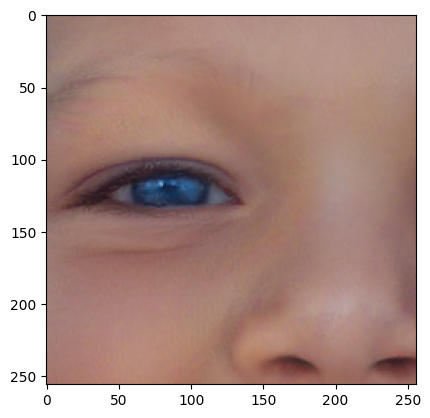

In [10]:
import matplotlib.pyplot as plt
# print(images[0])
plt.imshow(  images[1].permute(1, 2, 0))
print(labels[0].item())

In [11]:
# Initialize CNN
K = 2000 # total number of exemplars
icarl = iCaRLNet(2048,2,model_state_dict)
icarl.cuda()

# icarl.update_representation(train_dataset)

iCaRLNet(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [12]:
m = int(K / icarl.n_classes)
# icarl.reduce_exemplar_sets(m)

In [13]:
import torchvision.transforms as transforms

transform_test = transforms.Compose([
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [14]:
# Construct exemplar sets for new classes
for y in range(icarl.n_known, icarl.n_classes):
    print("Constructing exemplar set for class-%d..." %(y))
    # images = train_dataset.get_image_class(y).transpose(0,3,2,1)
    # Need subset of train_dataset
    # Identify indices of samples with the desired label
    filtered_indices = [i for i, (idx, _, label) in enumerate(train_dataset) if label == y]
    
    subset_dataset = Subset(train_dataset, filtered_indices)
    
    icarl.construct_exemplar_set(subset_dataset, m, transform_test)
    print("Done")

Constructing exemplar set for class-0...
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 495
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected example 354
Selected examp

In [76]:
subset_dataset[i][1].numpy().shape

(3, 256, 256)

In [ ]:
print("Some GAN Images")
k=20
idx = random.sample(range(len(subset_dataset)),k)
print(idx)
# Set up the figure and axes
fig, axes = plt.subplots(nrows=int(k/10), ncols=10, figsize=(k, 5))  # figsize can be adjusted as needed

axes = axes.flatten()
for i, ax in enumerate(axes):
    # Display image i in subplot
    ax.imshow(subset_dataset[idx[i]][1].numpy().transpose(1,2,0))  # Use cmap='gray' for grayscale images
    ax.axis('off')  # Optionally turn off the axis
    ax.set_title(f'Image {i+1}')  # Optional title for each subplot

plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()



In [94]:
for y, P_y in enumerate(icarl.exemplar_sets):
    print("Exemplar set for class-%d:" % (y), P_y.shape)
    #show_images(P_y[:10])

icarl.n_known = icarl.n_classes
print("iCaRL classes: %d" % icarl.n_known)

Exemplar set for class-0: (1000, 3, 256, 256)
Exemplar set for class-1: (1000, 3, 256, 256)
iCaRL classes: 2


In [ ]:
# Checking how many uniques in the exemplar set
from collections import Counter
for i in range(0,2):
    exemplar_images = icarl.exemplar_sets[i]
    print(exemplar_images.shape)
    images_reshaped = exemplar_images.reshape(exemplar_images.shape[0], -1)

    images_bytes = images_reshaped.view(np.uint8)

    _, unique_indices = np.unique(images_bytes, axis=0, return_index=True)
    
    num_unique_images = len(unique_indices)
    print(f"Number of unique images: {num_unique_images}")
    

(1000, 3, 256, 256)
Number of unique images: 992
(1000, 3, 256, 256)


### Showing random 20 images from exemplar set

In [84]:
import matplotlib.pyplot as plt
import random
def show_random_exemplar(np_array, k=20):  # np_array is of shape 1000,3,256,256
    idx = random.sample(range(len(np_array)),k)
    print(idx)
    # Set up the figure and axes
    fig, axes = plt.subplots(nrows=int(k/10), ncols=10, figsize=(k, 5))  # figsize can be adjusted as needed
    
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        # Display image i in subplot
        ax.imshow(np_array[idx[i]].transpose(1,2,0))  # Use cmap='gray' for grayscale images
        ax.axis('off')  # Optionally turn off the axis
        ax.set_title(f'Image {i+1}')  # Optional title for each subplot
    
    plt.tight_layout()  # Adjust subplots to fit in the figure area
    plt.show()

Real Exemplars
[469, 478, 411, 877, 359, 258, 867, 81, 184, 940, 962, 186, 523, 331, 829, 365, 661, 265, 651, 707]


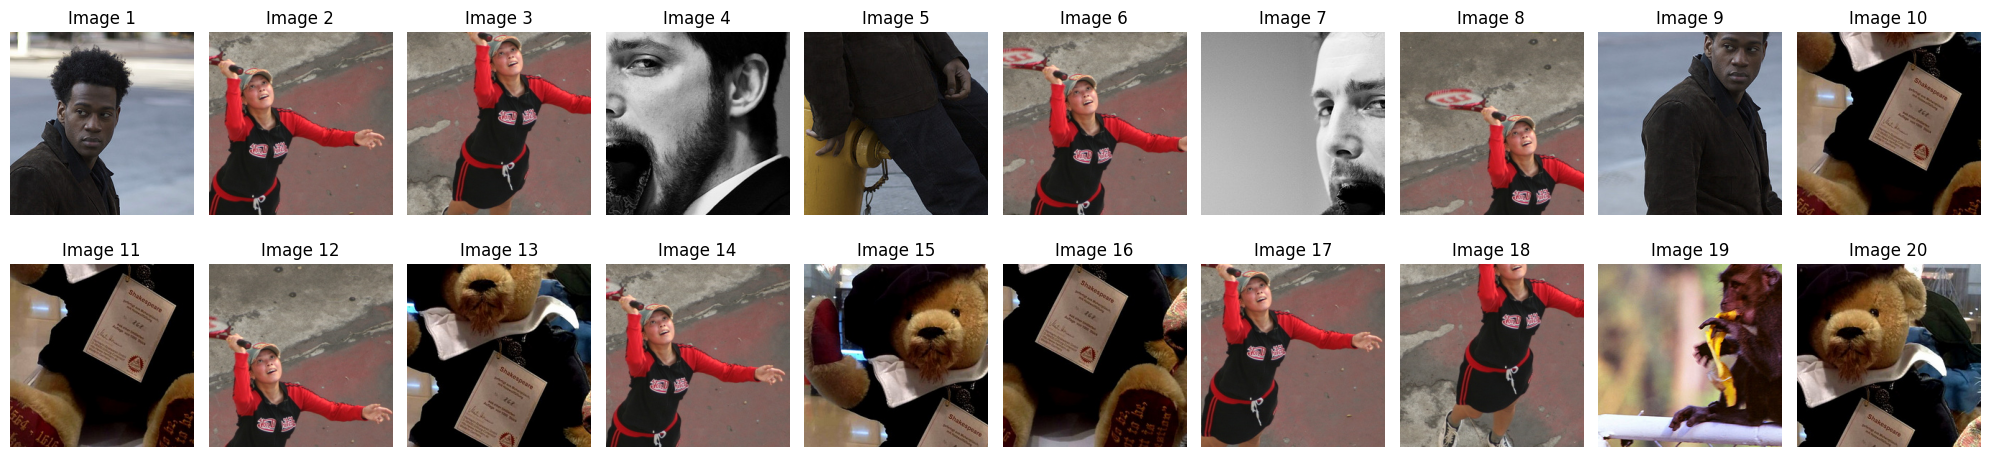

In [89]:
print('Real Exemplars')
show_random_exemplar(icarl.exemplar_sets[0],20)

GAN Exemplars
[637, 919, 84, 80, 34, 219, 494, 200, 43, 857, 738, 344, 983, 96, 61, 629, 672, 151, 979, 773]


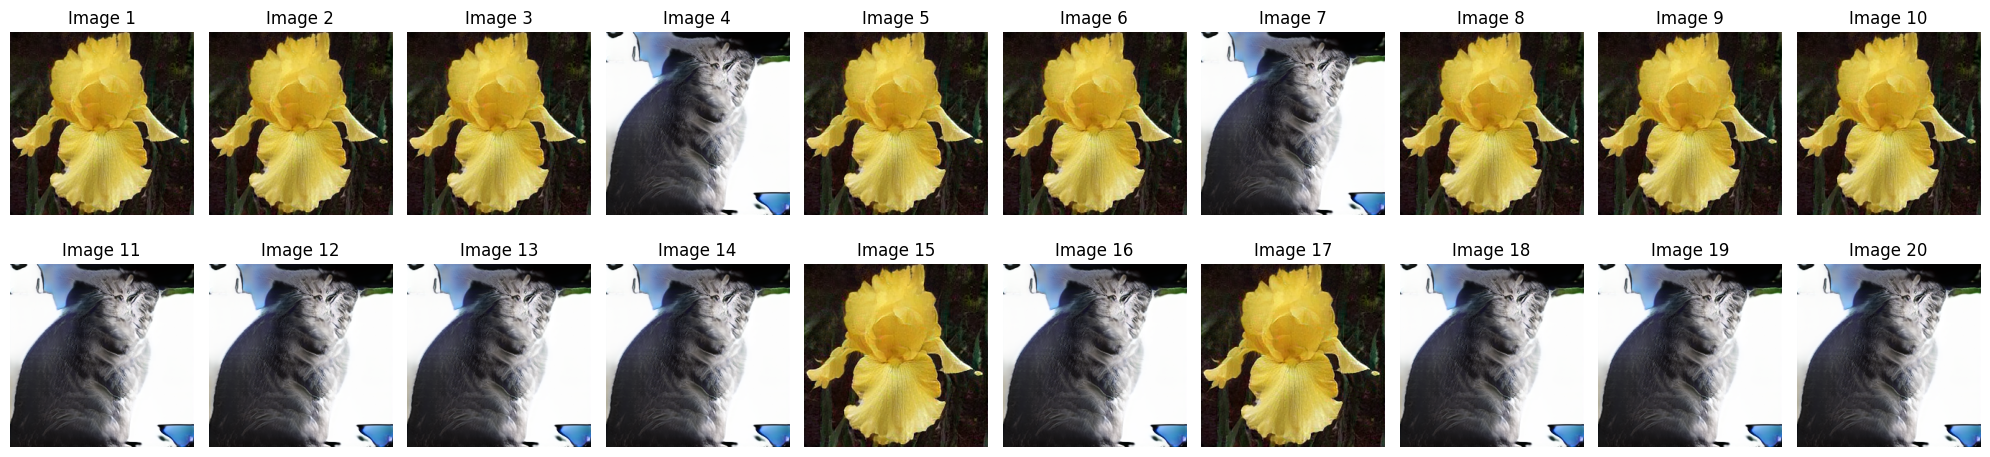

In [87]:
print('GAN Exemplars')
show_random_exemplar(icarl.exemplar_sets[1],20)

### Calculate accuracy

In [15]:
total = 0.0
correct = 0.0

for idx,images, labels in train_dataloader:
    images = Variable(images).cuda()
    # print(type(images), images.shape)
    preds = icarl.classify(images, transform)
    total += labels.size(0)
    correct += (preds.data.cpu() == labels).sum()

print('Train Accuracy: %f %%' % (100 * correct / total))

Computing mean of exemplars...
Done
Train Accuracy: 26.400000 %


In [ ]:
preds,labels

In [ ]:
total, correct

#### Now, create dataset for diffusion model 
and run the iCarl to see how well it does.

In [19]:
transform = transforms.Compose([
        transforms.RandomCrop(256),
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Scenario 2: Real vs Diffusion
txt_file_paths = ['', 'data/dn_sd/train.txt']  
train_dataset = CustomDataset(txt_file_paths=txt_file_paths, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# txt_file_paths = ['data/dn_real/test.txt', 'data/dn_sd/test.txt']  
# test_dataset = CustomDataset(txt_file_paths=txt_file_paths, transform=transform)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [20]:
train_dataset[0]

(0,
 tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.7765, 0.7765, 0.7804],
          [0.0000, 0.0000, 0.0000,  ..., 0.7804, 0.7804, 0.7843],
          [0.0000, 0.0000, 0.0000,  ..., 0.7804, 0.7804, 0.7843],
          ...,
          [0.2980, 0.3098, 0.3137,  ..., 0.0863, 0.3373, 0.0235],
          [0.3020, 0.3098, 0.3137,  ..., 0.0039, 0.0196, 0.0118],
          [0.3020, 0.3098, 0.3137,  ..., 0.0118, 0.0235, 0.0118]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.7098, 0.7098, 0.7137],
          [0.0000, 0.0000, 0.0000,  ..., 0.7137, 0.7137, 0.7176],
          [0.0000, 0.0000, 0.0000,  ..., 0.7137, 0.7137, 0.7176],
          ...,
          [0.2588, 0.2627, 0.2588,  ..., 0.0824, 0.3373, 0.0196],
          [0.2627, 0.2627, 0.2588,  ..., 0.0000, 0.0157, 0.0078],
          [0.2627, 0.2627, 0.2588,  ..., 0.0078, 0.0196, 0.0078]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6078, 0.6078, 0.6118],
          [0.0000, 0.0000, 0.0000,  ..., 0.6118, 0.6118, 0.6157],
          [0.0000, 0.0000, 0.0000,  

In [21]:
### Define dataset for diffusion model data
for indices, images, labels in train_dataloader:
    print(labels)
    break

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0])


In [22]:
icarl.update_representation(train_dataset)

0 new classes
Epoch [1/20], Iter [10/125] Loss: 1.9338
Epoch [1/20], Iter [20/125] Loss: 1.9526
Epoch [1/20], Iter [30/125] Loss: 1.9223
Epoch [1/20], Iter [40/125] Loss: 1.8294
Epoch [1/20], Iter [50/125] Loss: 1.8268
Epoch [1/20], Iter [60/125] Loss: 2.0057
Epoch [1/20], Iter [70/125] Loss: 1.8510
Epoch [1/20], Iter [80/125] Loss: 1.8686
Epoch [1/20], Iter [90/125] Loss: 1.9006
Epoch [1/20], Iter [100/125] Loss: 1.9737
Epoch [1/20], Iter [110/125] Loss: 1.9468
Epoch [1/20], Iter [120/125] Loss: 1.7897
Epoch [2/20], Iter [10/125] Loss: 1.9147
Epoch [2/20], Iter [20/125] Loss: 1.9054
Epoch [2/20], Iter [30/125] Loss: 1.8550
Epoch [2/20], Iter [40/125] Loss: 1.8429
Epoch [2/20], Iter [50/125] Loss: 1.8383
Epoch [2/20], Iter [60/125] Loss: 1.8710
Epoch [2/20], Iter [70/125] Loss: 1.8670
Epoch [2/20], Iter [80/125] Loss: 1.8601
Epoch [2/20], Iter [90/125] Loss: 1.8248
Epoch [2/20], Iter [100/125] Loss: 1.9518
Epoch [2/20], Iter [110/125] Loss: 2.0023
Epoch [2/20], Iter [120/125] Loss: 1.8

In [23]:
dataset = icarl.combine_dataset_with_exemplars(train_dataset)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                       shuffle=True)

dataset[3500][1].shape, dataset[0][1].shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [24]:
m = int(K / icarl.n_classes)

# Reduce exemplar sets for known classes
icarl.reduce_exemplar_sets(m)


In [25]:
# Construct exemplar sets for new classes
for y in range(icarl.n_known, icarl.n_classes):
    print ("Constructing exemplar set for class-%d..." %(y))
    images = train_set.get_image_class(y)
    icarl.construct_exemplar_set(images, m, transform_test)
    print ("Done")

for y, P_y in enumerate(icarl.exemplar_sets):
    print ("Exemplar set for class-%d:" % (y), P_y.shape)
    #show_images(P_y[:10])

icarl.n_known = icarl.n_classes
print ("iCaRL classes: %d" % icarl.n_known)

Exemplar set for class-0: (1000, 3, 256, 256)
Exemplar set for class-1: (1000, 3, 256, 256)
iCaRL classes: 2


In [27]:
total = 0.0
correct = 0.0
for indices, images, labels in test_dataloader:
    images = Variable(images).cuda()
    preds = icarl.classify(images, transform_test)
    total += labels.size(0)
    correct += (preds.data.cpu() == labels).sum()

print('Diffusion vs Real Test Accuracy: %d %%' % (100 * correct / total))

Diffusion vs Real Test Accuracy: 79 %


### Testing the model performance

In [28]:
# Scenario 1: Real vs GAN
txt_file_paths = ['/media/nas2/Aref/share/dataset_file_paths/db-real/test.txt', '/media/nas2/Aref/share/dataset_file_paths/db-gan/test.txt']  
test_dataset = CustomDataset(txt_file_paths=txt_file_paths, transform=transform)
test_rg_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [29]:
total = 0.0
correct = 0.0
tp, fp, fn, tn =0,0,0,0

count = 1
for indices, images, labels in test_rg_dataloader:
    images = Variable(images).cuda()
    preds = icarl.classify(images, transform_test)
    preds_np = preds.data.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    total += labels_np.size
    correct += (preds_np == labels_np).sum()
    
    # Calculate TP, FP, FN, TN
    tp += ((preds_np == 1) & (labels_np == 1)).sum()
    fp += ((preds_np == 1) & (labels_np == 0)).sum()
    fn += ((preds_np == 0) & (labels_np == 1)).sum()
    tn += ((preds_np == 0) & (labels_np == 0)).sum()

    if count%100==0:
        print(f'{total} processed')
    count+=1

# print('Real vs GAN Test Accuracy: %d %%' % (100 * correct / total))

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp+fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print('Real vs GAN Test Accuracy: %d %%' % (100 * correct / total))
print('Real vs GAN Test F1 Score: %f' % f1)

3200.0 processed
6400.0 processed
9600.0 processed
12800.0 processed
16000.0 processed
19200.0 processed
22400.0 processed
25600.0 processed
28800.0 processed
32000.0 processed
35200.0 processed
38400.0 processed
Real vs GAN Test Accuracy: 73 %
Real vs GAN Test F1 Score: 0.722615


In [30]:
# Calculate precision, recall, and F1 score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp+fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print('Real vs GAN Test Accuracy: %d %%' % (100 * correct / total))
print('Real vs GAN Test F1 Score: %f' % f1)


Real vs GAN Test Accuracy: 73 %
Real vs GAN Test F1 Score: 0.722615


In [31]:
# Scenario 2: Real vs Diffusion
txt_file_paths = ['/media/nas2/Aref/share/dataset_file_paths/db-real/test.txt', '/media/nas2/Aref/share/dataset_file_paths/stable_diffusion/test.txt']  
test_dataset = CustomDataset(txt_file_paths=txt_file_paths, transform=transform)
test_rd_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

total = 0.0
correct = 0.0
tp, fp, fn, tn =0,0,0,0

count = 1
for indices, images, labels in test_rd_dataloader:
    images = Variable(images).cuda()
    preds = icarl.classify(images, transform_test)
    preds_np = preds.data.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    total += labels_np.size
    correct += (preds_np == labels_np).sum()
    
    # Calculate TP, FP, FN, TN
    tp += ((preds_np == 1) & (labels_np == 1)).sum()
    fp += ((preds_np == 1) & (labels_np == 0)).sum()
    fn += ((preds_np == 0) & (labels_np == 1)).sum()
    tn += ((preds_np == 0) & (labels_np == 0)).sum()

    if count%100==0:
        print(f'{total} processed')
    count+=1

print('Real vs Diffusion Test Accuracy: %d %%' % (100 * correct / total))

3200.0 processed
6400.0 processed
9600.0 processed
12800.0 processed
16000.0 processed
19200.0 processed
22400.0 processed
25600.0 processed
28800.0 processed
32000.0 processed
35200.0 processed
38400.0 processed
Real vs Diffusion Test Accuracy: 79 %


In [32]:
# Calculate precision, recall, and F1 score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp+fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print('Real vs Diffusion Test Accuracy: %d %%' % (100 * correct / total))
print('Real vs Diffusion Test F1 Score: %f' % f1)

Real vs Diffusion Test Accuracy: 79 %
Real vs Diffusion Test F1 Score: 0.800184
